In [1]:
from experiment import SpacedRepetitionModel, read_data
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, spearmanr
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def model_eval(method, input_file, max_lines=None, omit_bias = True, omit_lexemes= True, omit_h_term= True):
    trainset, testset = read_data(input_file, method, omit_bias, omit_lexemes, max_lines)
    model = SpacedRepetitionModel(method=method, omit_h_term=omit_h_term)
    model.train(trainset)
    model.eval(testset, 'test')
    if not os.path.exists('results/'+method+'/'):
        os.makedirs('results/'+method+'/')
    model.dump_weights(f'results/{method}/h-weights')
    model.dump_predictions(f'results/{method}/h-preds', testset)

    


def sr_evaluate(preds_file):
    print(f'%%%%%%%%%%%%%%%%%% {preds_file} %%%%%%%%%%%%%%%%%%')
    data = pd.read_csv(preds_file, sep='\t')

    print('==== mean absolute error ====')
    p_minus_pp = abs(data['p'] - data['pp'])
    p_minus_mean_p = abs(data['p'] - data['p'].mean())
    print(f'MAE: {p_minus_pp.mean()}')
    print(f'MAE (baseline): {p_minus_mean_p.mean()}')
    _, p_value = ttest_ind(p_minus_pp, p_minus_mean_p)
    print(f'p-value: {p_value}')

    print('==== area under the ROC curve ====') 
    roc_auc = roc_auc_score(data['p'].round(), data['pp'])
    print(f'ROC AUC: {roc_auc}')

    _, p_value = wilcoxon(data['p'].round(), data['pp'], alternative='greater')
    print(f'p-value: {p_value}')

    print('==== half-life correlation ====')
    corr_coef, p_value = spearmanr(data['h'], data['hh'])
    print(f'Spearman correlation coefficient: {corr_coef}')
    print(f'p-value: {p_value}')


In [ ]:
model_eval('hlr', 'sample.csv', omit_h_term=False)

In [ ]:
model_eval('pimsleur', 'sample.csv')

In [3]:
sample_df = pd.read_csv("sample.csv")

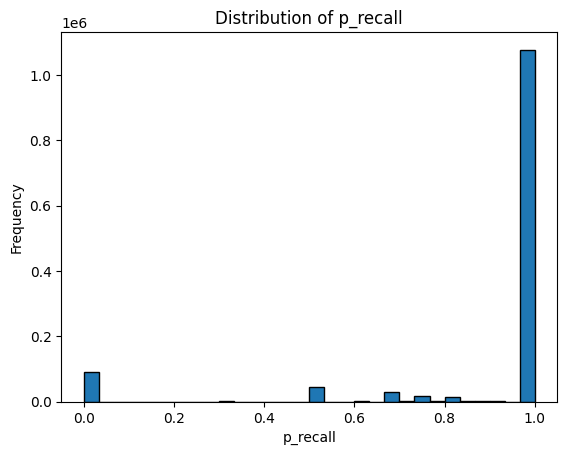

In [4]:
plt.hist(sample_df['p_recall'], bins=30, edgecolor='black')
plt.title('Distribution of p_recall')
plt.xlabel('p_recall')
plt.ylabel('Frequency')
plt.show()

In [9]:
#do some basic data analysis
print(sample_df.describe())

           p_recall     timestamp         delta  history_seen  \
count  1.285423e+06  1.285423e+06  1.285423e+06  1.285423e+06   
mean   8.957956e-01  1.362589e+09  7.292616e+05  2.205702e+01   
std    2.717910e-01  2.931792e+05  2.251216e+06  1.276641e+02   
min    0.000000e+00  1.362076e+09  1.000000e+00  1.000000e+00   
25%    1.000000e+00  1.362342e+09  5.320000e+02  3.000000e+00   
50%    1.000000e+00  1.362591e+09  7.692600e+04  6.000000e+00   
75%    1.000000e+00  1.362845e+09  4.421525e+05  1.500000e+01   
max    1.000000e+00  1.363105e+09  4.032836e+07  1.349700e+04   

       history_correct  session_seen  session_correct  
count     1.285423e+06  1.285423e+06     1.285423e+06  
mean      1.941138e+01  1.816607e+00     1.643041e+00  
std       1.096213e+02  1.356779e+00     1.317443e+00  
min       1.000000e+00  1.000000e+00     0.000000e+00  
25%       3.000000e+00  1.000000e+00     1.000000e+00  
50%       6.000000e+00  1.000000e+00     1.000000e+00  
75%       1.300000e+01

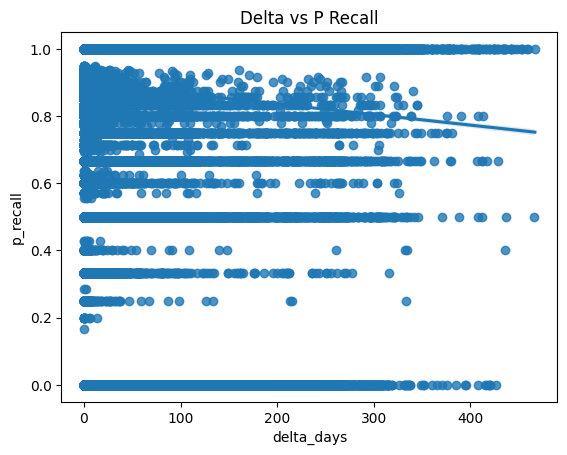

In [14]:
import seaborn as sns

# Plot delta against p_recall with regression line
sample_df['delta_days'] = sample_df['delta'] / (60 * 60 * 24)
sns.regplot(x='delta_days', y='p_recall', data=sample_df)

# Set the title
plt.title('Delta vs P Recall')

# Show the plot
plt.show()


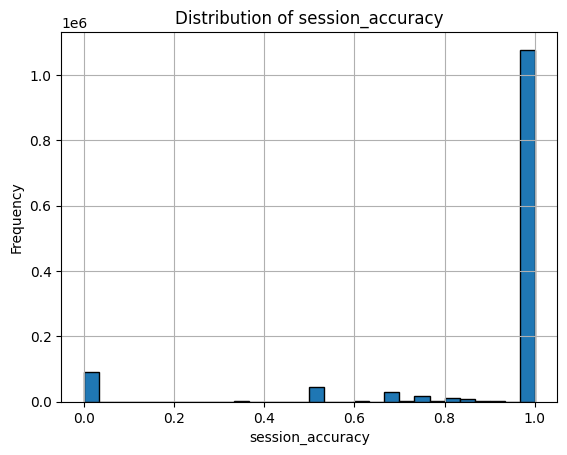

In [9]:
sample_df['session_accuracy'] = sample_df['session_correct'] / sample_df['session_seen']
sample_df.to_csv('sample.csv', index=False)

sample_df['session_accuracy'].hist(bins=30, edgecolor='black')
plt.title('Distribution of session_accuracy')
plt.xlabel('session_accuracy')
plt.ylabel('Frequency')
plt.show()

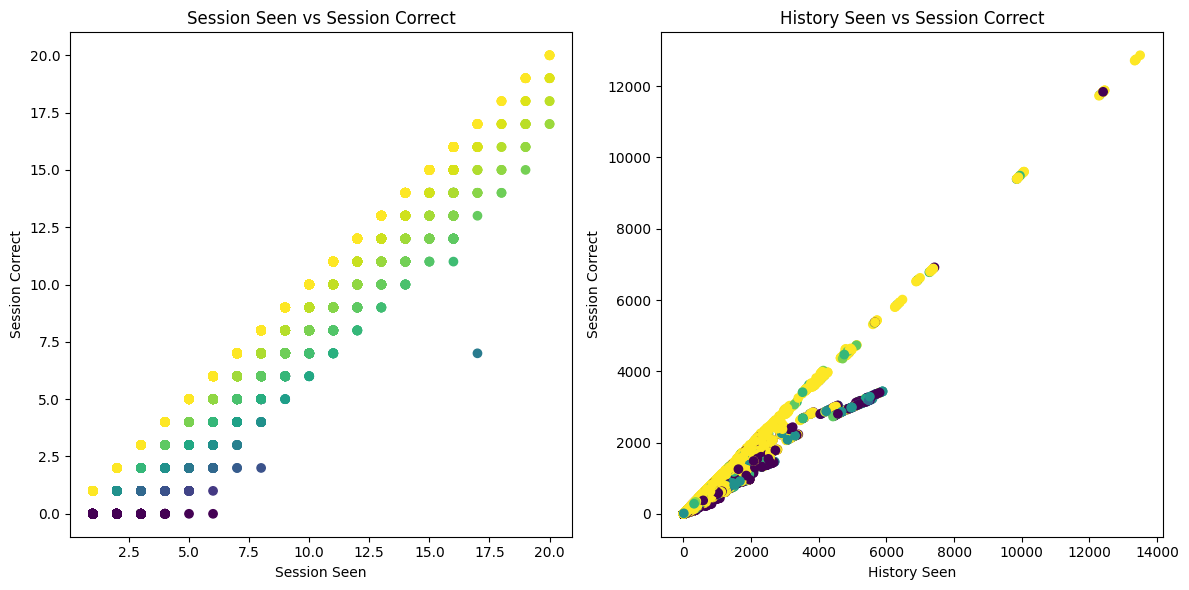

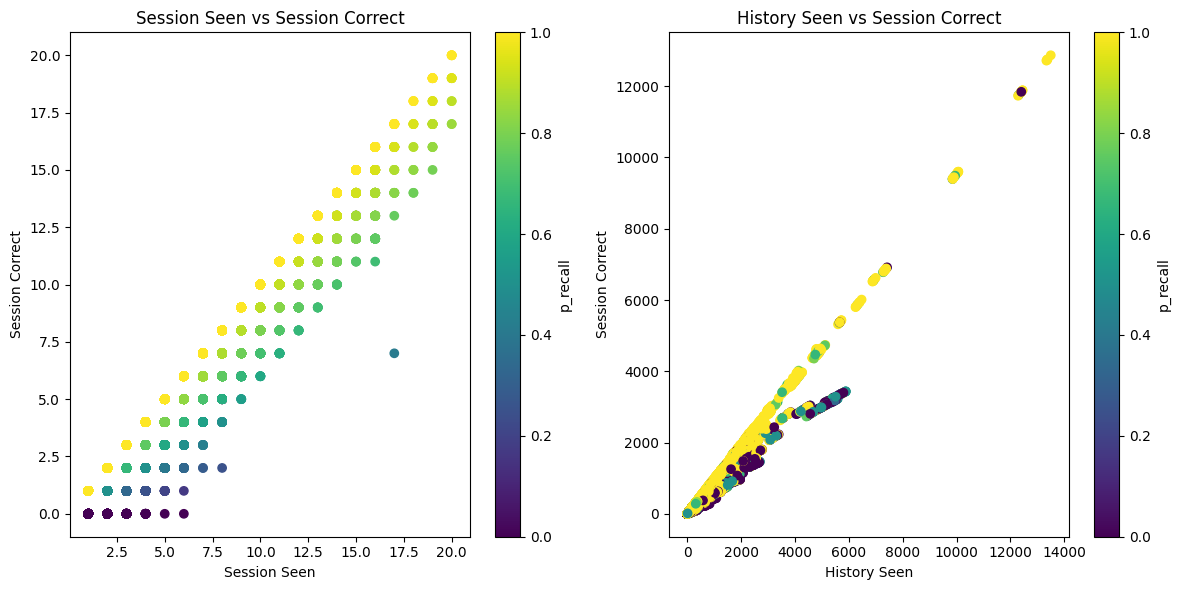

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot session seen vs session correct
scatter1 = axes[0].scatter(sample_df['session_seen'], sample_df['session_correct'], c=sample_df['p_recall'])
axes[0].set_xlabel('Session Seen')
axes[0].set_ylabel('Session Correct')
axes[0].set_title('Session Seen vs Session Correct')

# Plot history seen vs session correct
scatter2 = axes[1].scatter(sample_df['history_seen'], sample_df['history_correct'], c=sample_df['p_recall'])
axes[1].set_xlabel('History Seen')
axes[1].set_ylabel('Session Correct')
axes[1].set_title('History Seen vs Session Correct')

# Add legend
fig.colorbar(scatter1, ax=axes[0], label='p_recall')
fig.colorbar(scatter2, ax=axes[1], label='p_recall')

plt.tight_layout()
plt.show()



In [8]:
print(sample_df['delta'][:30])


0         285
1       24067
2        4062
3     1209220
4      321336
5       18483
6         502
7      273149
8         736
9     3164813
10     228963
11     220489
12     859130
13       1234
14      15531
15        726
16    2461818
17     174309
18     602354
19        431
20        218
21    1022610
22        193
23        142
24        323
25        412
26     241049
27        228
28      23910
29        383
Name: delta, dtype: int64


In [ ]:
# Group the sample_df dataframe by learning_language and ui_language and calculate the mean of p_recall and delta
average_values = sample_df.groupby(['learning_language'])[['p_recall']].mean()

# Reset the index to convert the grouped data into a DataFrame
average_values = average_values.sort_values(by='p_recall', ascending=False)
average_values = average_values.reset_index()
print(average_values)

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.plot(average_values.index, average_values['p_recall'], color='blue', label='p_recall')


# Set the x-axis labels
plt.xticks(average_values.index, average_values['learning_language'], rotation=90)

# Set the y-axis label
plt.ylabel('Average Value')

# Set the title
plt.title('Sorted Average p_recall by Learning Language')

# Add a legend
plt.legend()

# Show the plot
plt.show()



In [ ]:
ui_language_counts = sample_df['ui_language'].value_counts()
language_counts = sample_df['learning_language'].value_counts()

for i in range(len(language_counts)):
    if i < len(ui_language_counts):
        print(f'Language: {language_counts.index[i].upper()}, Count: {language_counts[i]}, UI Count: {ui_language_counts[i]}')
    else:
        print(f'Language: {language_counts.index[i].upper()}, Count: {language_counts[i]}')


In [ ]:
grouped = sample_df.groupby('learning_language')
even_languages_df = pd.DataFrame()

for group_name, group_df in grouped:
    group_sample = group_df.sample(n=30000, random_state=42)
    even_languages_df = pd.concat([even_languages_df, group_sample])

even_languages_df['learning_language'].value_counts()


In [ ]:
# Group the sample_df dataframe by learning_language and ui_language and calculate the mean of p_recall and delta
average_values = even_languages_df.groupby(['learning_language'])[['p_recall']].mean()

# Reset the index to convert the grouped data into a DataFrame
average_values = average_values.sort_values(by='p_recall', ascending=False)
average_values = average_values.reset_index()
print(average_values)

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.plot(average_values.index, average_values['p_recall'], color='blue', label='p_recall')


# Set the x-axis labels
plt.xticks(average_values.index, average_values['learning_language'], rotation=90)

# Set the y-axis label
plt.ylabel('Average Value')

# Set the title
plt.title('Sorted Average p_recall by Learning Language')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
occurrences = sample_df[sample_df['learning_language'] == sample_df['ui_language']]
print(occurrences)


data about lexemes

In [ ]:
# add the word column to the even_languages_df
sample_df['word'] = sample_df['lexeme_string'].str.extract(r'/(.*?)<', expand=False)
sample_df.to_csv('sample.csv', index=False)


In [ ]:
sample_df.drop(['lexeme_id'], axis=1).head(5)


In [ ]:
en_words = sample_df[sample_df['learning_language'] == 'en']
en_words['word'].value_counts()


In [ ]:
sp_words = sample_df[sample_df['learning_language'] == 'es']
sp_words['word'].value_counts()

In [ ]:
import wordcloud 

word_counts = en_words['word'].value_counts()

# Convert the word counts to a dictionary
word_freq_dict = word_counts.to_dict()
del word_freq_dict['prpers']

wc = wordcloud.WordCloud(width=800, height=400, background_color="white")

# Generate the word cloud
wc.generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
word_counts = sp_words['word'].value_counts()

# Convert the word counts to a dictionary
word_freq_dict = word_counts.to_dict()
del word_freq_dict['prpers']

wc = wordcloud.WordCloud(width=800, height=400, background_color="white")

# Generate the word cloud
wc.generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### try to incorporate randomforestregressor

In [ ]:
from statistics import mean
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your data is loaded into a pandas DataFrame named 'data'

# Separate features and target variable
features = ['timestamp', 'delta', 'history_seen', 'history_correct', 'session_seen', 'session_correct']
target = 'p_recall'

# Define number of folds for cross-validation
n_folds = 5

# Initialize lists to store results
mse_scores = []
r2_scores = []
adj_r2_scores = []

# KFold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for train_index, test_index in kf.split(sample_df):
    X_train, X_test = sample_df.iloc[train_index][features], sample_df.iloc[test_index][features]
    y_train, y_test = sample_df.iloc[train_index][target], sample_df.iloc[test_index][target]

    # Create the random forest regression model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(features) - 1)

    # Store results
    mse_scores.append(mse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

# Calculate and print average scores
print("Random Forest Regression Evaluation (KFold Cross-Validation):")
print(f"Average Mean Squared Error: {mean(mse_scores):.4f}")
print(f"Average R-squared: {mean(r2_scores):.4f}")
print(f"Average Adjusted R-squared: {mean(adj_r2_scores):.4f}")



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Define your features and target
features = ['timestamp', 'delta', 'history_seen', 'history_correct', 'session_seen', 'session_correct']
target = 'p_recall'

# Split your data into training and testing sets
X = sample_df[features]
y = sample_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
noise = np.random.normal(0, 0.01, size=X_train.shape)
X_train_noisy = X_train + noise

# Log-transform the target variable
y_train_log = np.log1p(y_train)

# Initialize a RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_noisy, y_train_log)

# Make predictions
predictions_log = rf.predict(X_test)
predictions = np.expm1(predictions_log)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.4f}")

# Calculate the R-squared
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2:.4f}")

# Calculate the adjusted R-squared
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(features) - 1)
print(f"Adjusted R-squared: {adj_r2:.4f}")

# Plot the feature importances
importances = rf.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# plot fitted vs residuals
residuals = y_test - predictions
plt.figure(figsize=(8, 5)) 
plt.scatter(predictions, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted vs Residuals')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()


In [ ]:
from scipy.optimize import curve_fit

# Define the bi-exponential decay function
def bi_exponential(x, a, b, c, d):
    return a * np.exp(-b * x) + c * np.exp(-d * x)

# Get the x and y values from your DataFrame
smaller_sample = sample_df.sample(frac=0.1, random_state=42)


x = smaller_sample['delta'].values
y = smaller_sample['p_recall'].values


# Fit the bi-exponential decay function to your data
popt, pcov = curve_fit(bi_exponential, x, y, p0=(1, 1e-6, 1, 1e-6))

x_fit = np.linspace(x.min(), x.max(), 1000)

# Compute the y values of the fitted function
y_fit = bi_exponential(x_fit, *popt)


# Plot the random sample
plt.scatter(x, y, label='Random Sample')

# Plot the fitted function
plt.plot(x_fit, y_fit, 'r', label='Fitted function')

plt.xlabel('Delta')
plt.ylabel('p_recall')
plt.title('Bi-exponential decay fit')
plt.legend()
plt.show()

# Print the optimal parameters
print(f"a = {popt[0]}, b = {popt[1]}, c = {popt[2]}, d = {popt[3]}")

In [ ]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k*(x - x0)))

# Fit the logistic growth function to your data
popt, pcov = curve_fit(logistic, x, y, p0=(max(y), 1, np.median(x)))

# Print the optimal parameters
print(f"L = {popt[0]}, k = {popt[1]}, x0 = {popt[2]}")

# Generate x values for the fitted function
x_fit = np.linspace(x.min(), x.max(), 1000)

# Compute the y values of the fitted function
y_fit = logistic(x_fit, *popt)

# Plot the original data
plt.scatter(x, y, label='Original data')

# Plot the fitted function
plt.plot(x_fit, y_fit, 'r', label='Fitted function')
plt.xlabel('Delta')
plt.ylabel('p_recall')
plt.title('Logistic growth fit')
plt.legend()
plt.show()


In [15]:
sample_df.to_csv('sample.csv', index=False)

In [ ]:
# Define the half-life regression function
def half_life(x, a, t):
    return a * np.exp(-np.log(2) * x / t)

# Fit the half-life regression function to your data
popt, pcov = curve_fit(half_life, x, y, p0=(max(y), np.median(x)))

# Print the optimal parameters
print(f"a = {popt[0]}, t = {popt[1]}")

# Generate x values for the fitted function
x_fit = np.linspace(x.min(), x.max(), 1000)

# Compute the y values of the fitted function
y_fit = half_life(x_fit, *popt)

# Plot the fitted function
plt.plot(x_fit, y_fit, 'r', label='Fitted function')

plt.xlabel('Delta')
plt.ylabel('p_recall')
plt.title('Half-life regression fit')
plt.legend()
plt.show()

In [ ]:
def language_model_eval(lang, method, input_file, max_lines=None, omit_bias = True, omit_lexemes= True, omit_h_term= True):
    trainset, testset = read_data(input_file, method, omit_bias, omit_lexemes, max_lines)
    model = SpacedRepetitionModel(method=method, omit_h_term=omit_h_term)
    model.train(trainset)
    model.eval(testset, 'test')
    if not os.path.exists('results/'+'/'+method+'/'):
        os.makedirs('results/'+method+'/')
    model.dump_weights(f'results/lang-hlr/{lang}-weights')
    model.dump_predictions(f'results/lang-hlr/{lang}-preds', testset)

In [ ]:
en_df = sample_df[sample_df['learning_language'] == 'en']
es_df = sample_df[sample_df['learning_language'] == 'es']
fr_df = sample_df[sample_df['learning_language'] == 'fr']
de_df = sample_df[sample_df['learning_language'] == 'de']
it_df = sample_df[sample_df['learning_language'] == 'it']
nl_df = sample_df[sample_df['learning_language'] == 'pt']

In [ ]:
language_model_eval('en', 'hlr', 'sample.csv')
language_model_eval('es', 'hlr', 'sample.csv')
language_model_eval('fr', 'hlr', 'sample.csv')
language_model_eval('de', 'hlr', 'sample.csv')
language_model_eval('it', 'hlr', 'sample.csv')
language_model_eval('pt', 'hlr', 'sample.csv')



In [ ]:
sr_evaluate('results/lang-hlr/en-preds')
sr_evaluate('results/lang-hlr/es-preds')
sr_evaluate('results/lang-hlr/fr-preds')
sr_evaluate('results/lang-hlr/de-preds')
sr_evaluate('results/lang-hlr/it-preds')